In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import nibabel as nib
from tqdm import tqdm

import analytics
import writer 

from skimage import morphology as morpho
from skimage.measure import label
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

In [21]:
def apply_mask(image, mask):
    """
    image: numpy.ndarray : segmented array.
    mask: numpy.ndarray : mask array of the associated img.

    return: numpy.ndarray: the masked image.
    """
    return image * mask

def binarize(seg, img_mask):
    """
    Binarizes an image.
    seg: numpy.ndarray : segmented array.
    img_mask: numpy.ndarray : mask array of the associated img.

    return: numpy.ndarray : binarized image. 
    """
    seg_2d = np.zeros((seg.shape[0:3]))
    for i, s in enumerate(seg):
        gray = rgb2gray(s)
        # Otsu raises ValueError if single grayscale value.
        if len(np.unique(gray)) > 1:
            ots =  threshold_otsu(gray)
            seg_2d[i] = (gray > ots).astype(int)
            # remove borders
            seg_2d[i] *= morpho.erosion(img_mask[i], morpho.disk(2))
        else:
            seg_2d[i] = np.zeros((gray.shape))
    return seg_2d

filepath = "result_09.nii"
maskpath = "VESSEL12_09.nii"#+os.listdir("../data/lung_mask")[0]

analytics.result = {}
img_mask = nib.load(maskpath).get_fdata()
print("loading\n", flush=True)
# segmentation
print("loading segmentation...\n", flush=True)
seg = nib.load(filepath).get_fdata()


loading

loading segmentation...



In [23]:
seg.shape, img_mask.shape
seg = seg[490:500]
img_mask = img_mask[490:500]

In [24]:
# post processing
print("applying some post processing...\n", flush=True)
seg = apply_mask(seg, img_mask)
seg_2d = binarize(seg, img_mask)
print("End of slice processing\n", flush=True) 
distance_map, skel = analytics.distance(seg_2d)
print("distance\n", flush=True)

applying some post processing...



<ipython-input-21-34aa390fc0f6>:20: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = rgb2gray(s)


End of slice processing

distance



In [25]:
import numpy as np
# from copy import deepcopy
from scipy import ndimage as ndi
from skimage.measure import label
from skimage.morphology import skeletonize

In [ ]:
def distance(seg, verbose=False):
    """
    Computes the distance map of a segmentation.

    seg: numpy.ndarray : segmented array
    verbose: bool : display log option.

    return: numpy.ndarray : a distance map.
    """
    if verbose:
        print("computing distance map...")
    distance_map = ndi.distance_transform_edt(seg)
    skel = skeletonize(seg)
    if verbose:
        plt.imshow(distance_map[185])
    return distance_map, skel

In [71]:
dist, skel = distance(seg)

In [84]:
label_map, label_nbr = label(dist, return_num=True)

result["component_count"] = label_nbr

print(label_nbr, flush=True)
label_map = label_map.flatten()
skel = skel.flatten()
dist_size = int(len(label_map) / 10000)
print("dist_size", dist_size)

dist = dist.flatten()
dist_per_label = [[] for i in range(label_nbr+1)];
for i in range(0, len(label_map)-dist_size, dist_size):
    label_map_i = label_map[i:i + dist_size]
    flat_dist_i = dist[i : i + dist_size]
    for k in np.unique(label_map_i): 
        if k == 0: # not a valid label
            continue
        sub = flat_dist_i[(label_map_i == k)]
        dist_per_label[k] += list(sub) # append labels to list 
print(dist_per_label[14])
#skel = np.array([dist[((skel != 0) & (label_map == i))]for i in range(label_nbr +1)])
dist_per_label = np.array([np.array(x, dtype=np.float64) for x in dist_per_label], dtype=object)
dist_per_label = dist_per_label[len(dist_per_label) > 1]

82
dist_size 262
[1.0]


In [85]:
dist_per_label

array([[array([], dtype=float64), array([1.]), array([1.]),
        array([1., 1., 1.]), array([1.]), array([1., 1.]), array([1.]),
        array([1., 1.]), array([1., 1.]), array([1.]), array([1.]),
        array([1.]), array([1.]), array([1., 1.]), array([1.]),
        array([1., 1.]), array([1., 1.]), array([1.]), array([1., 1.]),
        array([1.]), array([1.]), array([1., 1.]), array([1.]),
        array([1.]), array([1.]), array([1.]), array([1.]), array([1.]),
        array([1.]), array([1., 1.]), array([1.]), array([1.]),
        array([1.]), array([1.]), array([1.]), array([1.]), array([1.]),
        array([1.]), array([1.]), array([1.]), array([1., 1.]),
        array([1.]), array([1.]), array([1.]), array([1.]),
        array([1., 1.]), array([1.]), array([1.]), array([1.]),
        array([1., 1.]), array([1., 1.]), array([1.]), array([1.]),
        array([1., 1.]), array([1.]), array([1.]), array([1.]),
        array([1.]), array([1., 1.]), array([1.]), array([1.]),
      

KeyboardInterrupt: 

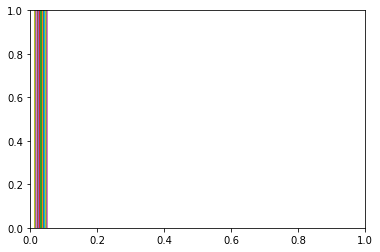

In [80]:
plt.hist(dist)

In [56]:
def get_analytics(img, mask, dist_per_label, skel, verbose=False):
    """
        Computes the metrics on all the labels, and fills the result array.

        img: numpy.ndarray : segmented array.
        mask: numpy.ndarray : mask array of the associated img.
        dist_per_label: numpy.ndarray : distance array per label.
        verbose: bool : display log option.
    """
    numvox = np.count_nonzero(img)
    result["voxel_nbr"] = numvox
    result["lung_pixels"] = np.count_nonzero(mask)
    if verbose:
        print('Number of voxel containing vessles: ', numvox)

    f_mean = np.vectorize(lambda x : x.mean() if x.any() else None)
    mean_ = f_mean(dist_per_label)
    mean_ = mean_[~np.isnan(mean_.astype(np.float64))] #remove the Nones
    f_max = np.vectorize(lambda x : x.max() if x.any() else None)
    max_ = f_max(dist_per_label)
    max_ = max_[~np.isnan(max_.astype(np.float64))] #remove the Nones
    result["mean_mean_all_vessel"] = mean_.mean() if mean_.any() else None
    result["std_deviation"] = np.std(mean_) if mean_.any() else None
    result["max_max_all_vessel"] = max_.max() if max_.any() else None
    result["min_max_all_vessel"] = max_.min() if max_.any() else None
    result["mean_max_all_vessel"] = max_.mean() if max_.any() else None
    result["mean_all_vessel"] = mean_
    print("most computations are done\n", flush=True)
    result["max_all_vessel"] = max_

In [57]:
result = {}
dist_per_label , skel= label_value(distance_map, skel)

get_analytics(seg, img_mask, dist_per_label, skel, verbose=True)

16
dist_size 262
k  14
sub  1
0.0
k  14
sub  1
0.0
[1.0, 1.0]
Number of voxel containing vessles:  112
most computations are done



In [51]:
result

{'component_count': 16,
 'voxel_nbr': 112,
 'lung_pixels': 43696,
 'mean_mean_all_vessel': 1.0,
 'std_deviation': 0.0,
 'max_max_all_vessel': 1.0,
 'min_max_all_vessel': 1.0,
 'mean_max_all_vessel': 1.0,
 'mean_all_vessel': array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
        1.0, 1.0, 1.0], dtype=object),
 'max_all_vessel': array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
        1.0, 1.0, 1.0], dtype=object)}